In [45]:
import sys
sys.path.insert(1, '../model')
import model
import linear_model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from scipy.integrate import solve_ivp

In [3]:
raw = pd.read_csv("../data/covid_19_data.csv")

In [4]:
#load population dict
population_df = pd.read_csv("../data/locations_population.csv")
population_country = population_df[population_df['Country.Region'] == "Czechia"].iloc[0]['Population']
population_country = int(population_country)
print(population_country) 

10650000


In [5]:
raw

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
22830,22831,05/08/2020,Wyoming,US,2020-05-09 02:32:35,644.0,7.0,0.0
22831,22832,05/08/2020,Xinjiang,Mainland China,2020-05-09 02:32:35,76.0,3.0,73.0
22832,22833,05/08/2020,Yukon,Canada,2020-05-09 02:32:35,11.0,0.0,0.0
22833,22834,05/08/2020,Yunnan,Mainland China,2020-05-09 02:32:35,185.0,2.0,182.0


In [6]:
data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Country"] = df["Country/Region"]
df.loc[df["Country"] == "Diamond Princess", ["Country", "Province"]] = ["Others", "Diamond Princess"]
df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
df[data_cols_all] = df[data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
ncov_df_ungrouped.tail()

,Date,Country,Province,Confirmed,Infected,Deaths,Recovered
22830,2020-05-08,US,Wyoming,644,637,7,0
22831,2020-05-08,Mainland China,Xinjiang,76,0,3,73
22832,2020-05-08,Canada,Yukon,11,11,0,0
22833,2020-05-08,Mainland China,Yunnan,185,1,2,182
22834,2020-05-08,Mainland China,Zhejiang,1268,0,1,1267


In [7]:
df_germany = ncov_df_ungrouped.loc[ncov_df_ungrouped["Country"] == "Czech Republic", :].groupby("Date").sum()
df_germany['Country'] = 'Czech Republic'
df_germany['Province'] = None
df_germany.tail()

,Confirmed,Infected,Deaths,Recovered,Country,Province
Date,,,,,,
2020-05-04,7819,3760,252,3807,Czech Republic,None
2020-05-05,7896,3633,257,4006,Czech Republic,None
2020-05-06,7974,3507,262,4205,Czech Republic,None
2020-05-07,8031,3390,270,4371,Czech Republic,None
2020-05-08,8077,3391,273,4413,Czech Republic,None


In [8]:
df_test = pd.read_csv("../data/full-list-total-tests-for-covid-19.csv")
df_test.rename({"Cumulative total tests": "TotalTests"}, axis=1,inplace=True)
df_test["Date"] = pd.to_datetime(df_test["Date"])
df_test_germany = df_test[df_test['Entity'] == 'Czech Republic']
df_test_germany.tail()

,Entity,Code,Date,TotalTests
281,Czech Republic,CZE,2020-04-09,114854
282,Czech Republic,CZE,2020-04-10,120285
283,Czech Republic,CZE,2020-04-11,125126
284,Czech Republic,CZE,2020-04-12,128359
285,Czech Republic,CZE,2020-04-13,131542


In [9]:
result = pd.merge(df_germany,
                 df_test_germany[['Date','TotalTests']],
                 on='Date',
                 how = 'left')
from numpy import isnan
result.loc[0, ('TotalTests')] = 0 if isnan(result['TotalTests'][0]) else result['TotalTests'][0]
result['TotalTests'].interpolate(method='linear',inplace=True,limit_direction='both')
result['TotalTests'] = result['TotalTests'].astype(int)
border_date = '2020-05-02'
training = result[(result['Date'] > '2020-01-01') & (result['Date'] < border_date)]
test = result[result['Date'] >= border_date]
result.tail()


,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
64,2020-05-04,7819,3760,252,3807,Czech Republic,None,131542
65,2020-05-05,7896,3633,257,4006,Czech Republic,None,131542
66,2020-05-06,7974,3507,262,4205,Czech Republic,None,131542
67,2020-05-07,8031,3390,270,4371,Czech Republic,None,131542
68,2020-05-08,8077,3391,273,4413,Czech Republic,None,131542


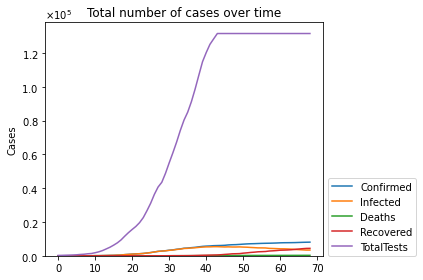

In [10]:
data_cols_all += ['TotalTests']
model.line_plot(result[data_cols_all], "Total number of cases over time")

In [11]:
ger_scenario = model.Scenario(training, name="Czech Republic", places=[("Czech Republic", None)])

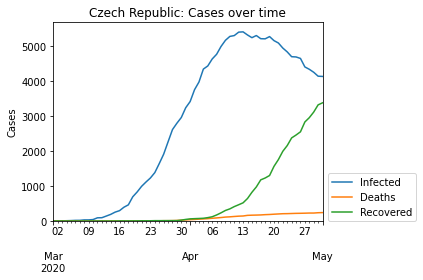

,Date,Confirmed,Infected,Deaths,Recovered
57,2020-04-27,7445,4396,223,2826
58,2020-04-28,7504,4329,227,2948
59,2020-04-29,7579,4244,227,3108
60,2020-04-30,7682,4132,236,3314
61,2020-05-01,7737,4125,240,3372


In [12]:
ger_scenario.show_record().tail()

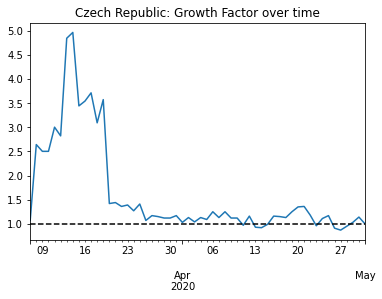

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Czech Republic,2020-05-01,Crossroad,0,0


In [13]:
ger_scenario.growth_factor()

In [14]:
result.loc[result['Date'] == '2020-04-13']

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
43,2020-04-13,6059,5397,143,519,Czech Republic,None,131542


In [15]:
ger_scenario.set_phase(
    start_dates=["25Mar2020","07Apr2020","22Apr2020"],
    population=population_country
)

,start_date,end_date,population
1st,25Mar2020,06Apr2020,10650000
2nd,07Apr2020,21Apr2020,10650000
3rd,22Apr2020,-,10650000


In [16]:
ger_scenario.estimate(model.SIR)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Total: 0 min 23 sec.


In [17]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,rho,sigma,Rt,score,1/beta [day],1/gamma [day]
1st,25Mar2020,06Apr2020,10650000,1161,0.084099,0.003916,21.48,0.173409,9,205
2nd,07Apr2020,21Apr2020,10650000,1161,0.024213,0.017513,1.38,0.077224,33,46
3rd,22Apr2020,-,10650000,1161,0.011620,0.030417,0.38,0.012761,69,26


../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


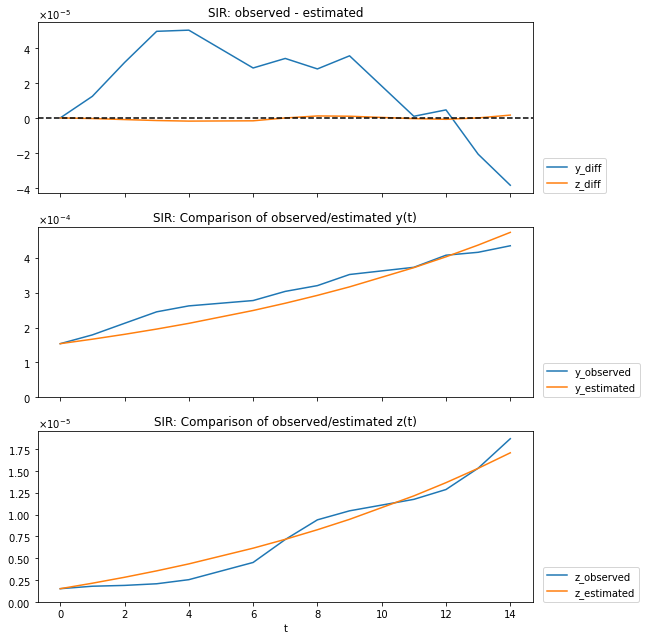

In [18]:
ger_scenario.accuracy_graph(phase_n=1)

../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


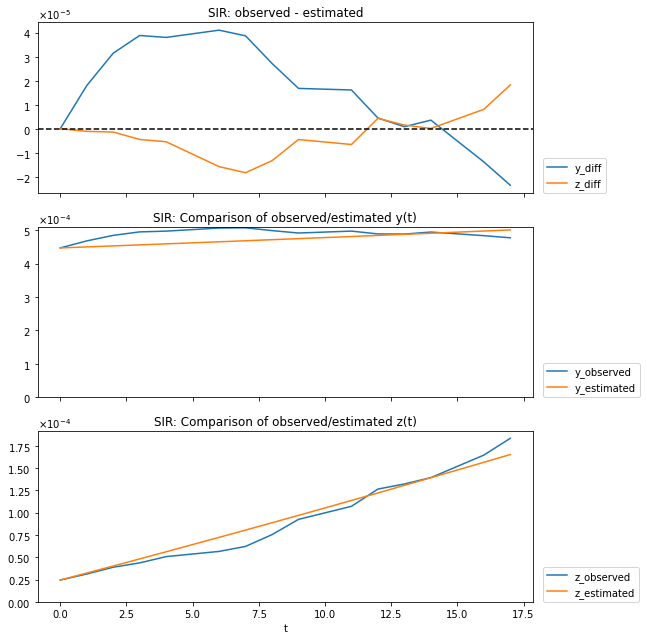

In [19]:
ger_scenario.accuracy_graph(phase_n=2)

../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


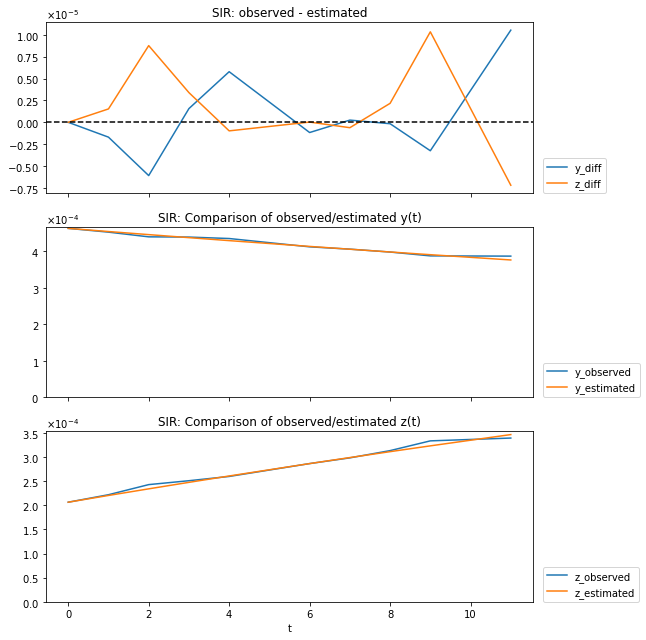

In [20]:
ger_scenario.accuracy_graph(phase_n=3)

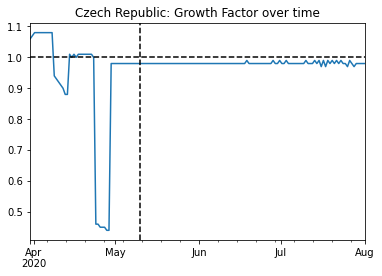

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Czech Republic,2020-08-01,Stopping,0,124


In [21]:
ger_scenario.growth_factor(days_to_predict=100)

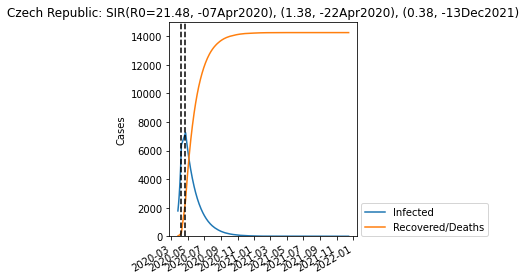

In [22]:
df_sir = ger_scenario.predict(days=600)

In [23]:
df_sir.loc['2020-05-02':'2020-05-08']

,Susceptible,Infected,Recovered/Deaths
Time,,,
2020-05-02 16:48:00,10639310,5797,4892
2020-05-03 12:09:00,10639243,5689,5067
2020-05-04 07:30:00,10639178,5583,5238
2020-05-05 02:51:00,10639113,5478,5407
2020-05-05 22:12:00,10639050,5376,5572
2020-05-06 17:33:00,10638989,5276,5734
2020-05-07 12:54:00,10638928,5178,5893
2020-05-08 08:15:00,10638868,5081,6049


SEIR MODEL

In [24]:
ger_scenario.set_phase(
    start_dates=["25Mar2020","07Apr2020","22Apr2020"],
    population=population_country
)

,start_date,end_date,population
1st,25Mar2020,06Apr2020,10650000
2nd,07Apr2020,21Apr2020,10650000
3rd,22Apr2020,-,10650000


In [25]:
ger_scenario.estimate(model.SIRD)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 9 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Total: 0 min 25 sec.


In [26]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,kappa,rho,sigma,Rt,score,1/alpha2 [day],1/beta [day],1/gamma [day]
1st,25Mar2020,06Apr2020,10650000,764,0.001042,0.052700,0.001543,20.38,0.266027,509,10,343
2nd,07Apr2020,21Apr2020,10650000,764,0.000817,0.015009,0.010203,1.36,0.118429,649,35,51
3rd,22Apr2020,-,10650000,764,0.000431,0.007924,0.019228,0.40,0.015751,1230,66,27


../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


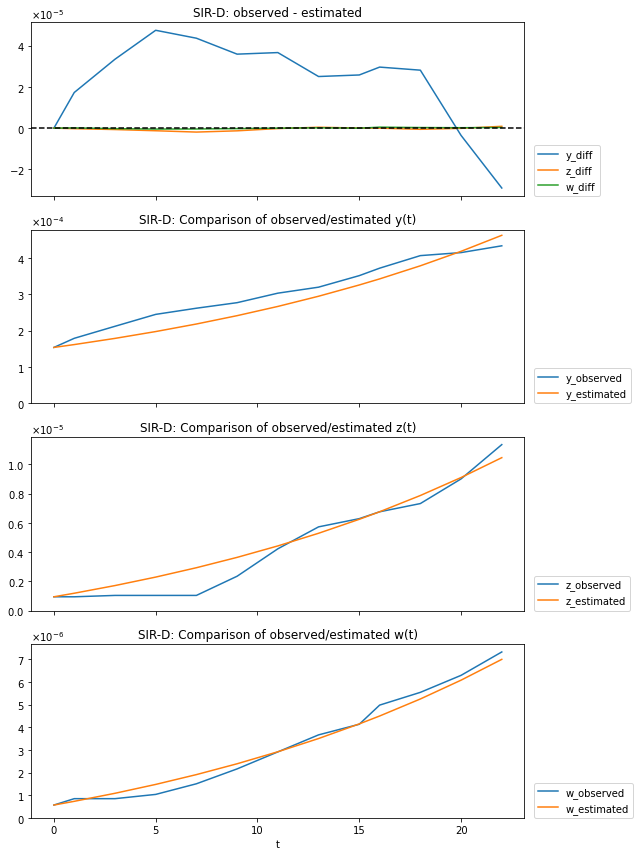

In [27]:
ger_scenario.accuracy_graph(phase_n=1)

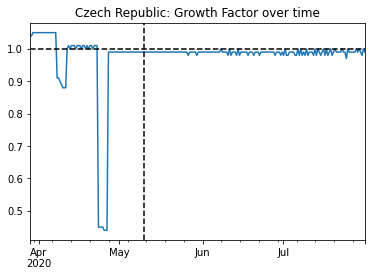

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Czech Republic,2020-07-31 09:28:00,Crossroad,0,1


In [28]:
ger_scenario.growth_factor(days_to_predict=100)

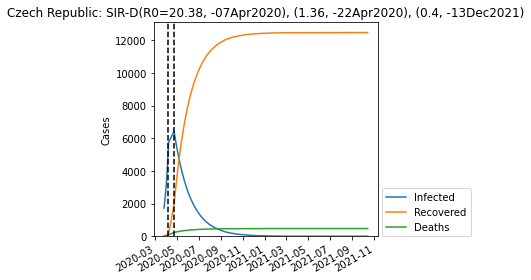

In [29]:
df_seir = ger_scenario.predict(days=600)

In [30]:
df_seir.loc['2020-05-02':'2020-05-08']

,Susceptible,Infected,Recovered,Deaths
Time,,,,
2020-05-02 04:48:00,10640572,5206,3940,280
2020-05-02 17:32:00,10640531,5146,4039,282
2020-05-03 06:16:00,10640491,5085,4138,284
2020-05-03 19:00:00,10640451,5026,4235,286
2020-05-04 07:44:00,10640411,4967,4331,288
2020-05-04 20:28:00,10640372,4909,4426,290
2020-05-05 09:12:00,10640333,4852,4520,293
2020-05-05 21:56:00,10640295,4795,4613,295
2020-05-06 10:40:00,10640258,4739,4704,297


SEIRD MODEL

In [31]:
ger_scenario.estimate(model.SIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 12 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 10 sec.
	Successfully estimated.
Total: 1 min 17 sec.


In [32]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,theta,kappa,rho,sigma,Rt,score,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
1st,25Mar2020,06Apr2020,10650000,1304,0.026351,0.000191,0.081561,0.002823,26.35,0.316843,0.026,4747,11,320
2nd,07Apr2020,21Apr2020,10650000,1304,0.022543,0.001092,0.026662,0.018884,1.30,0.118300,0.023,829,33,47
3rd,22Apr2020,-,10650000,1304,0.024422,0.000260,0.014006,0.035251,0.38,0.015068,0.024,3488,64,25


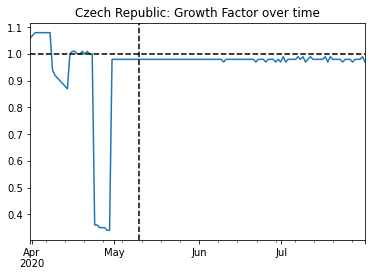

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Czech Republic,2020-07-31 14:08:00,Stopping,0,110


In [33]:
ger_scenario.growth_factor(days_to_predict=100)

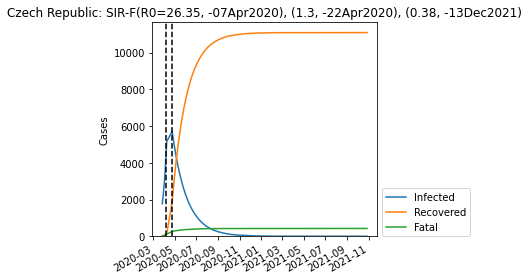

In [34]:
df_seird = ger_scenario.predict(days=600)

In [36]:
df_seird.loc['2020-05-02':'2020-05-08']

,Susceptible,Infected,Recovered,Fatal,Confirmed
Time,,,,,
2020-05-02 00:48:00,10641420,4589,3690,300,8579
2020-05-02 22:32:00,10641356,4489,3850,303,8642
2020-05-03 20:16:00,10641294,4392,4006,305,8703
2020-05-04 18:00:00,10641233,4297,4159,308,8764
2020-05-05 15:44:00,10641174,4204,4309,311,8824
2020-05-06 13:28:00,10641116,4113,4456,313,8882
2020-05-07 11:12:00,10641059,4025,4599,316,8940
2020-05-08 08:56:00,10641003,3938,4740,318,8996


SEWIRF

In [37]:
ger_scenario.estimate(model.SEWIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 13 sec.
		100 trials finished in 0 min 15 sec.
		100 trials finished in 0 min 16 sec.
		100 trials finished in 0 min 17 sec.
		100 trials finished in 0 min 18 sec.
		100 trials finished in 0 min 19 sec.
		100 trials finished in 0 min 20 sec.
		100 trials finished in 0 min 22 sec.
		100 trials finished in 0 min 23 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 11 sec.
	Estimator will be replaced because estimated w is non-monotonic.
	Estimator was created.
		100 trials finished in 0 min 9 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 10 sec.
		100 tr

In [38]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,theta,kappa,rho1,rho2,rho3,sigma,Rt,score,alpha1 [-],1/alpha2 [day],1/beta1 [day],1/beta2 [day],1/beta3 [day],1/gamma [day]
1st,25Mar2020,06Apr2020,10650000,814,0.000742,0.000944,0.109950,0.666143,0.125635,0.001750,40.78,0.311652,0.001,598,5,0,4,322
2nd,07Apr2020,21Apr2020,10650000,814,0.285967,0.000117,0.089106,0.004708,0.326633,0.014523,4.35,0.255110,0.286,4834,6,120,1,38
3rd,22Apr2020,-,10650000,814,0.047856,0.000350,0.105412,0.020080,0.297609,0.019890,4.96,0.037151,0.048,1613,5,28,1,28


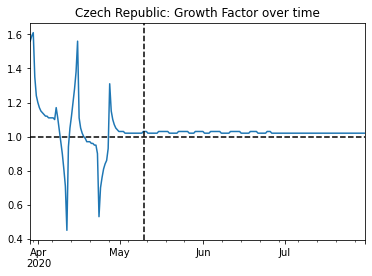

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Czech Republic,2020-07-30 18:04:00,Outbreaking,168,0


In [39]:
ger_scenario.growth_factor(days_to_predict=100)

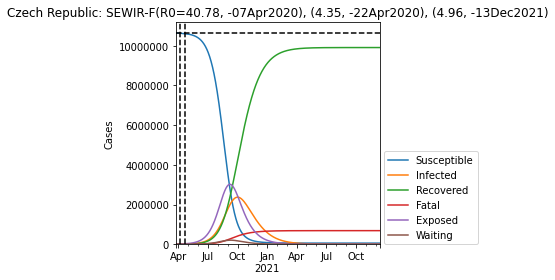

In [40]:
df_sewirf = ger_scenario.predict(days=600)

In [41]:
df_sewirf.loc['2020-05-02':'2020-05-08']

,Susceptible,Infected,Recovered,Fatal,Exposed,Waiting,Confirmed
Time,,,,,,,
2020-05-02 10:32:00,10588610,13092,7447,2583,36019,2245,23122
2020-05-03 00:06:00,10586980,13468,7711,2620,36917,2300,23799
2020-05-03 13:40:00,10585304,13853,7983,2658,37842,2356,24494
2020-05-04 03:14:00,10583583,14247,8262,2697,38794,2413,25206
2020-05-04 16:48:00,10581813,14649,8550,2737,39775,2473,25936
2020-05-05 06:22:00,10579995,15058,8845,2778,40784,2537,26681
2020-05-05 19:56:00,10578128,15476,9149,2820,41822,2603,27445
2020-05-06 09:30:00,10576209,15903,9461,2863,42890,2671,28227
2020-05-06 23:04:00,10574238,16341,9782,2907,43989,2740,29030


# comparison 

In [59]:
def getValuesVector(df, label):
    d = ''
    arr = []
    for index, row in df.loc['2020-05-02':'2020-05-08'].iterrows():
        ind = str(index).split(" ")[0]
        if (d == ind):
            arr[-1] = round((arr[-1] + row[label]) / 2, 0)
        else:
            arr.append(row[label])
        d = ind
    return arr

def getComparison(df_sewirf, df_seird, df_sird, df_sir, label):
    fit = linear_model.fitFuntion(training, label)
    x, y = linear_model.getDataSet(result, label)
    func = fit['function']
    popt = fit['popt']
     
    df = pd.DataFrame()
    df["sewirf_" + label] = getValuesVector(df_sewirf.loc['2020-05-02':'2020-05-08'], label)
    df["sirf_" + label] = getValuesVector(df_seird.loc['2020-05-02':'2020-05-08'], label)
    df["sird_" + label] = getValuesVector(df_sird.loc['2020-05-02':'2020-05-08'], label)
    df["sir_" + label] = getValuesVector(df_sir.loc['2020-05-02':'2020-05-08'], label)
    df["function_fit_" + label] = func(x, *popt)[-8:-1]
    df[label] = list(test[label])
    
    squareError = pd.DataFrame()
    squareError["sewirf_" + label] = np.square(list(df["sewirf_" + label] - df[label]))
    squareError["sirf_" + label] = np.square(list(df["sirf_" + label] - df[label]))
    squareError["sird_" + label] = np.square(list(df["sird_" + label] - df[label]))
    squareError["sir_" + label] = np.square(list(df["sir_" + label] - df[label]))
    squareError["function_fit_" + label] = np.square(list(df["function_fit_" + label] - df[label]))

    return (df, squareError)

In [60]:
comp, squareError = getComparison(df_sewirf, df_seird, df_seir, df_sir, "Infected")

/home/jakub/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [61]:
comp

,sewirf_Infected,sirf_Infected,sird_Infected,sir_Infected,function_fit_Infected,Infected
0,13092.0,4539.0,5176.0,5797.0,3516.474846,4049
1,13660.0,4392.0,5056.0,5689.0,3185.999969,3946
2,14448.0,4297.0,4938.0,5583.0,2825.159794,3760
3,15267.0,4204.0,4824.0,5427.0,2433.125048,3633
4,16122.0,4113.0,4712.0,5276.0,2009.066458,3507
5,16791.0,4025.0,4629.0,5178.0,1552.154752,3390
6,17489.0,3938.0,4548.0,5081.0,1061.560657,3391


In [62]:
squareError

,sewirf_Infected,sirf_Infected,sird_Infected,sir_Infected,function_fit_Infected
0,81775849.0,240100.0,1270129.0,3055504.0,2.835830e+05
1,94361796.0,198916.0,1232100.0,3038049.0,5.776000e+05
2,114233344.0,288369.0,1387684.0,3323329.0,8.739262e+05
3,135349956.0,326041.0,1418481.0,3218436.0,1.439700e+06
4,159138225.0,367236.0,1452025.0,3129361.0,2.243805e+06
5,179586801.0,403225.0,1535121.0,3196944.0,3.377675e+06
6,198753604.0,299209.0,1338649.0,2856100.0,5.426288e+06


In [63]:
1/7 * squareError.sum()

sewirf_Infected          1.375999e+08
sirf_Infected            3.032994e+05
sird_Infected            1.376313e+06
sir_Infected             3.116818e+06
function_fit_Infected    2.031797e+06
dtype: float64

PREDICTING IN PHASES

TRYING TO INCLUDE TESTS